May: **Research Questions 2.2** (Ideal and Real)

# Which of the three upwelling mechanisms (time dependence, advection, convergence of isobaths, coastal trapped wave) provides the strongest contribution to upwelling in Mackenzie Canyon?

At what depths does maximum upwelling occur?

In [23]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

In [24]:
def get_max_displacement(dirname, fname, meshmaskname, dep_ind, time_s, time_f, vosaline_ref_profile):

    vosaline, sozotaux, deptht, tmask = upwelling_functions.get_vars_salt(dirname, fname, meshmaskname, 
                                                                            dep_ind, time_s, time_f, None)
    max_vosaline = np.full([vosaline.shape[0]], np.nan)
    
    for t in range(vosaline.shape[0]):
        max_vosaline[t] = np.nanmax(vosaline[t, :, :])
        
    max_depth_ind = upwelling_functions.get_daily_depth_ind(max_vosaline, vosaline_ref_profile)
    original_depth, max_depth_upwelled = upwelling_functions.get_daily_depth_m(deptht, dep_ind, max_depth_ind, tmask)
        
    return original_depth, max_depth_upwelled, sozotaux, deptht

In [25]:
def plot_axes(axes, dep_inds, dirname, fname, meshmaskname, time_s, time_f, vosaline_ref_profile):
    
    canyon_depth = 506
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        Tmask = dsM.variables['tmask'][0, :, y, x]
    ys = np.arange(Tmask.shape[-2])
    cmap = LinearSegmentedColormap.from_list('mycmap', ['silver', 'white'])
    cm_times = np.linspace(0, 1, len(dep_inds))
    colors = [cmo.cm.matter(x) for x in cm_times]
    ts = np.arange(time_s+1, time_f+1)
    
    list_upw_depth_in_Z = []
    list_orig_depth_in_Z = []
    list_upw_depth_in_Z_canyon = []
    list_orig_depth_in_Z_canyon = []
    list_t_upw_depth_in_Z = []
    list_depths = []
    
    for dep_ind, c in zip (dep_inds, colors):
        
        orig_depth_in_TZ, upw_depth_in_TZ, sozotaux, deptht = get_max_displacement(dirname, fname, meshmaskname, dep_ind, time_s, time_f, vosaline_ref_profile)
        
        # depths examined
        list_depths.append(deptht[dep_ind])
        
        # maximum upwelling depth at every depth level in the domain
        upw_depth_in_Z = np.max(upw_depth_in_TZ)
        list_upw_depth_in_Z.append(upw_depth_in_Z)
        
        ind_upw_depth_in_Z = np.where(upw_depth_in_TZ == upw_depth_in_Z)[0][0] # time [hr] in python
        t_upw_depth_in_Z = ind_upw_depth_in_Z
        list_t_upw_depth_in_Z.append(t_upw_depth_in_Z)
        
        # original depth at every depth level in the domain
        orig_depth_in_Z = orig_depth_in_TZ[ind_upw_depth_in_Z]
        list_orig_depth_in_Z.append(orig_depth_in_Z)
        
        # maximum upwelling depth at every depth level solely inside the canyon
        # if original depth is within canyon
        if orig_depth_in_Z <= canyon_depth:
            list_upw_depth_in_Z_canyon.append(upw_depth_in_Z)
            list_orig_depth_in_Z_canyon.append(orig_depth_in_Z)
        elif orig_depth_in_Z > canyon_depth:
            list_upw_depth_in_Z_canyon.append(np.nan)
            list_orig_depth_in_Z_canyon.append(np.nan)
        
        print('dep ind:', dep_ind, ', dep [m]:', np.round(deptht[dep_ind], 3),
              ', max disp [m]:', np.round(upw_depth_in_Z, 3), ', orig dep [m]:', np.round(orig_depth_in_Z, 3),
              ', time [py-hr]:', t_upw_depth_in_Z, ', time [day]:', int(t_upw_depth_in_Z/24))
    
        axes[1, 1].plot(ts, upw_depth_in_TZ, c=c, lw=1.5, label=str(int(deptht[dep_ind])))
        axes[1, 1].xaxis.set_ticks(np.arange(time_s+1, time_f+1, 24))
        axes[1, 1].set_ylim([0, 300])
        axes[1, 1].set_xlim([0, ts[-1]])
        axes[1, 1].grid()
        axes[1, 0].axhline(deptht[dep_ind], c=c, lw=1.5)
    
    ind_mid = int(Tmask.shape[-1]*0.5)
    axes[1, 0].pcolormesh(ys, deptht, Tmask[:, :, ind_mid], cmap=cmap)
    axes[1, 0].set_ylim([1300, 0])
    
    #
    
    print('\nIn the', len(dep_inds), 'depth levels examined: ')
    
    # domain
    max_upw_depth = np.max(list_upw_depth_in_Z)
    ind = np.where(list_upw_depth_in_Z==max_upw_depth)[0][0]
    max_orig_depth = list_orig_depth_in_Z[ind]
    max_time = list_t_upw_depth_in_Z[ind]
    print('\nMax displacement anywhere in domain = ', max_upw_depth)
    print('with original depth ', max_orig_depth)
    print('and final depth ', deptht[dep_inds[ind]])
    print('at time [hrs] ', max_time, '(day ', int(max_time/24), ')')
    
    # canyon
    max_upw_depth = np.nanmax(list_upw_depth_in_Z_canyon)
    ind = np.where(list_upw_depth_in_Z_canyon==max_upw_depth)[0][0]
    max_orig_depth = list_orig_depth_in_Z_canyon[ind]
    max_time = list_t_upw_depth_in_Z[ind]
    print('\nMax displacement confined to the canyon = ', max_upw_depth)
    print('with original depth ', max_orig_depth)
    print('and final depth ', deptht[dep_inds[ind]])
    print('at time [hrs] ', max_time, '(day ', int(max_time/24), ')')
    
    # original depth = 220
    depth_nearest220 = min(list_orig_depth_in_Z, key=lambda x:abs(x-220))
    ind = np.where(list_orig_depth_in_Z==depth_nearest220)[0][0]
    max_upw_depth = list_upw_depth_in_Z[ind]
    final_depth = list_depths[ind]
    max_time = list_t_upw_depth_in_Z[ind]
    print('\nMax displacement of Pacific-Atlantic water (220 m) = ', max_upw_depth)
    print('with original depth ', depth_nearest220)
    print('and final depth', final_depth)
    print('at time [hrs] ', max_time, '(day ', int(max_time/24), ')')
    
    # final depth = 80
    depth_nearest80 = min(list_depths, key=lambda x:abs(x-80))
    ind = np.where(list_depths==depth_nearest80)[0][0]
    max_upw_depth = list_upw_depth_in_Z[ind]
    original_depth = list_orig_depth_in_Z[ind]
    max_time = list_t_upw_depth_in_Z[ind]
    print('\nMax displacement to the shelf break (80 m) = ', max_upw_depth)
    print('with original depth', original_depth)
    print('and final depth', depth_nearest80)
    print('at time [hrs] ', max_time, '(day ', int(max_time/24), ')')
        
    return axes, sozotaux

# 10 days & few depths

In [26]:
def execute_functions(dirname, fname, meshmaskname, time_s, time_f, dep_inds, vosaline_ref_profile, kind, case, flag):

    fig, axes = plt.subplots(2, 2, figsize=(20, 7), gridspec_kw={"width_ratios":[1, 3], "height_ratios":[1, 3]})
    fig.tight_layout(w_pad=0.5, h_pad=2)

    axes, sozotaux = plot_axes(axes, dep_inds, dirname, fname, meshmaskname, time_s, time_f, vosaline_ref_profile)
    
    ts = np.arange(time_s+1, time_f+1)
    axes[0, 0].remove()
    axes[0, 1].plot(ts, sozotaux, c='k', lw=2)
    axes[0, 1].xaxis.set_ticks(np.arange(time_s+1, time_f+1, 23))
    axes[0, 1].set_title('Wind Stress [$Nm^{-2}$]', fontsize=20)
    axes[0, 1].xaxis.set_ticks(np.arange(time_s+1, time_f+1, 24))
    axes[0, 1].set_xlim([0, ts[-1]])
    axes[0, 1].grid()
    
    plt.subplots_adjust(top=0.90)
    fig.suptitle(kind+' - '+case+': '+' maximum vertical displacement [m] at various depths', fontsize=30)
    
    fig.savefig('../writing_images/displaced_max_all_depths_'+kind+'_'+case+'_'+flag+'.png', dpi=100, bbox_inches='tight')
    
    return

In [27]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'

time_s = 0 # python count
time_f = 10*24 # python count

dep_inds = np.arange(0, 80, 5).tolist()

len(dep_inds)

16

# 5 days & all depths

In [30]:
time_s = 0 # python count
time_f = 6*24 # python count

dep_inds = np.arange(0, 80).tolist()

dep ind: 0 , dep [m]: 4.375 , max disp [m]: 113.75 , orig dep [m]: 118.125 , time [py-hr]: 83 , time [day]: 3
dep ind: 1 , dep [m]: 13.125 , max disp [m]: 113.75 , orig dep [m]: 126.875 , time [py-hr]: 82 , time [day]: 3
dep ind: 2 , dep [m]: 21.875 , max disp [m]: 113.75 , orig dep [m]: 135.625 , time [py-hr]: 91 , time [day]: 3
dep ind: 3 , dep [m]: 30.625 , max disp [m]: 105.0 , orig dep [m]: 135.625 , time [py-hr]: 78 , time [day]: 3
dep ind: 4 , dep [m]: 39.375 , max disp [m]: 105.0 , orig dep [m]: 144.375 , time [py-hr]: 66 , time [day]: 2
dep ind: 5 , dep [m]: 48.125 , max disp [m]: 113.75 , orig dep [m]: 161.875 , time [py-hr]: 68 , time [day]: 2
dep ind: 6 , dep [m]: 56.875 , max disp [m]: 113.75 , orig dep [m]: 170.625 , time [py-hr]: 61 , time [day]: 2
dep ind: 7 , dep [m]: 65.625 , max disp [m]: 113.75 , orig dep [m]: 179.375 , time [py-hr]: 52 , time [day]: 2
dep ind: 8 , dep [m]: 74.375 , max disp [m]: 113.75 , orig dep [m]: 188.125 , time [py-hr]: 47 , time [day]: 1
dep 

dep ind: 73 , dep [m]: 1065.868 , max disp [m]: 85.139 , orig dep [m]: 1151.007 , time [py-hr]: 50 , time [day]: 2
dep ind: 74 , dep [m]: 1108.438 , max disp [m]: 42.569 , orig dep [m]: 1151.007 , time [py-hr]: 17 , time [day]: 0
dep ind: 75 , dep [m]: 1151.007 , max disp [m]: 42.569 , orig dep [m]: 1193.576 , time [py-hr]: 20 , time [day]: 0
dep ind: 76 , dep [m]: 1193.576 , max disp [m]: 42.569 , orig dep [m]: 1236.146 , time [py-hr]: 26 , time [day]: 1
dep ind: 77 , dep [m]: 1236.146 , max disp [m]: 0.0 , orig dep [m]: 1236.146 , time [py-hr]: 0 , time [day]: 0
dep ind: 78 , dep [m]: 1278.715 , max disp [m]: 0.0 , orig dep [m]: 1278.715 , time [py-hr]: 0 , time [day]: 0
dep ind: 79 , dep [m]: 1321.285 , max disp [m]: -1316.91 , orig dep [m]: 4.375 , time [py-hr]: 0 , time [day]: 0

In the 80 depth levels examined: 

Max displacement anywhere in domain =  175.0
with original depth  336.875
and final depth  161.875
at time [hrs]  52 (day  2 )

Max displacement confined to the canyon =

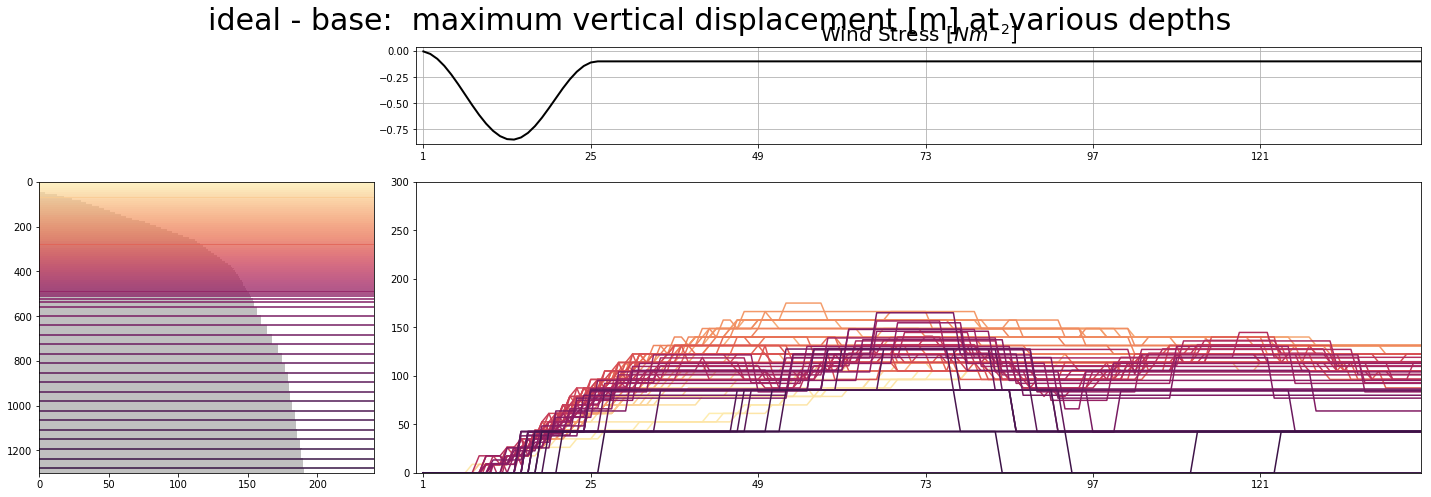

In [31]:
kind = 'ideal'
case = 'base'
flag = str(len(dep_inds))+'z_'+str(int(time_f/24))+'days'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
execute_functions(dirname, fname, meshmaskname, time_s, time_f, dep_inds, vosaline_ref_profile, kind, case, flag)

dep ind: 0 , dep [m]: 4.375 , max disp [m]: 43.75 , orig dep [m]: 48.125 , time [py-hr]: 28 , time [day]: 1
dep ind: 1 , dep [m]: 13.125 , max disp [m]: 52.5 , orig dep [m]: 65.625 , time [py-hr]: 22 , time [day]: 0
dep ind: 2 , dep [m]: 21.875 , max disp [m]: 70.0 , orig dep [m]: 91.875 , time [py-hr]: 24 , time [day]: 1
dep ind: 3 , dep [m]: 30.625 , max disp [m]: 87.5 , orig dep [m]: 118.125 , time [py-hr]: 34 , time [day]: 1
dep ind: 4 , dep [m]: 39.375 , max disp [m]: 87.5 , orig dep [m]: 126.875 , time [py-hr]: 33 , time [day]: 1
dep ind: 5 , dep [m]: 48.125 , max disp [m]: 87.5 , orig dep [m]: 135.625 , time [py-hr]: 33 , time [day]: 1
dep ind: 6 , dep [m]: 56.875 , max disp [m]: 87.5 , orig dep [m]: 144.375 , time [py-hr]: 36 , time [day]: 1
dep ind: 7 , dep [m]: 65.625 , max disp [m]: 78.75 , orig dep [m]: 144.375 , time [py-hr]: 30 , time [day]: 1
dep ind: 8 , dep [m]: 74.375 , max disp [m]: 78.75 , orig dep [m]: 153.125 , time [py-hr]: 35 , time [day]: 1
dep ind: 9 , dep [m]

dep ind: 73 , dep [m]: 1065.868 , max disp [m]: 85.139 , orig dep [m]: 1151.007 , time [py-hr]: 29 , time [day]: 1
dep ind: 74 , dep [m]: 1108.438 , max disp [m]: 85.139 , orig dep [m]: 1193.576 , time [py-hr]: 35 , time [day]: 1
dep ind: 75 , dep [m]: 1151.007 , max disp [m]: 42.569 , orig dep [m]: 1193.576 , time [py-hr]: 17 , time [day]: 0
dep ind: 76 , dep [m]: 1193.576 , max disp [m]: 42.569 , orig dep [m]: 1236.146 , time [py-hr]: 21 , time [day]: 0
dep ind: 77 , dep [m]: 1236.146 , max disp [m]: 42.569 , orig dep [m]: 1278.715 , time [py-hr]: 32 , time [day]: 1
dep ind: 78 , dep [m]: 1278.715 , max disp [m]: 0.0 , orig dep [m]: 1278.715 , time [py-hr]: 0 , time [day]: 0
dep ind: 79 , dep [m]: 1321.285 , max disp [m]: -1316.91 , orig dep [m]: 4.375 , time [py-hr]: 0 , time [day]: 0

In the 80 depth levels examined: 

Max displacement anywhere in domain =  248.43954
with original depth  725.3146
and final depth  476.87503
at time [hrs]  56 (day  2 )

Max displacement confined to t

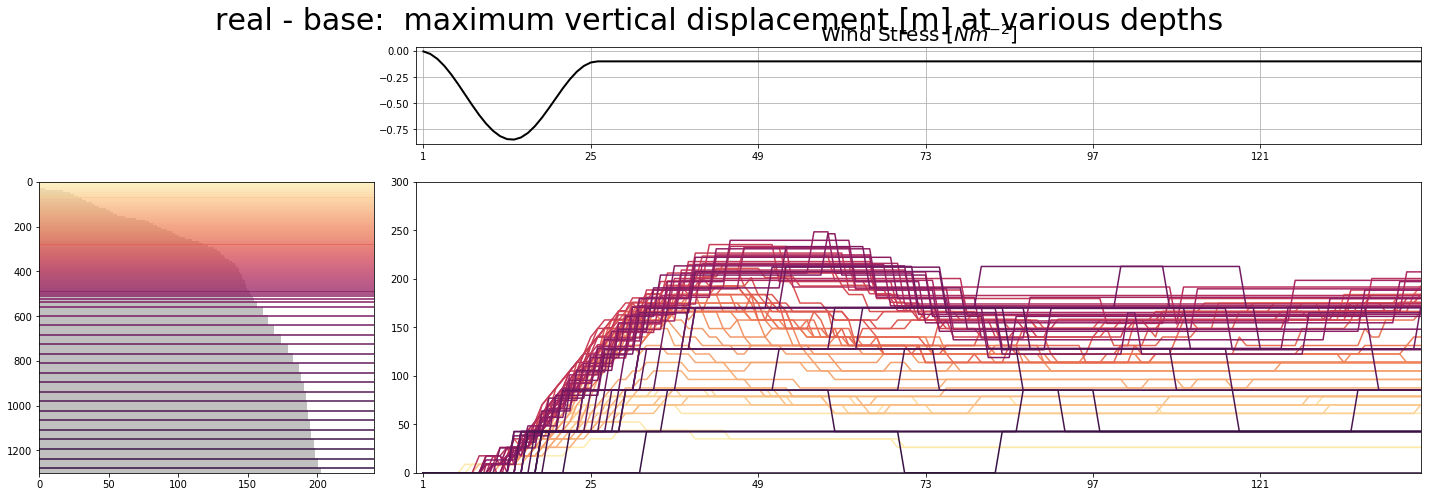

In [32]:
kind = 'real'
case = 'base'
flag = str(len(dep_inds))+'z_'+str(int(time_f/24))+'days'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
execute_functions(dirname, fname, meshmaskname, time_s, time_f, dep_inds, vosaline_ref_profile, kind, case, flag)